<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="5"> TAF MCE - 2020/2021</span></p>
<p><font size="4">  UE Stochastic Dynamic Models </font></p>
<p></p>
<p><font size="5"> Stochastic Differential Equations </font></p>
</p></br>
</p>
</CENTER>


----------------------------

# <span style="color:#00B8DE">I - Simulation of SDEs </span>

Let's consider the Black-Scholes stochastic differential equation : 
$$
dX_t = rX_tdt + aX_tdB_t
$$
with $r=-1$ and $a=1$.

We would like to implement Euler, Millstein and Runge-Kutta with order 1.5 methods to provide numericals solutions to this equation.

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

### 1 - First we define a function **Gauss(m=0,v=1)** that returns a function that takes an argument $x$ and returns the value $\mathcal{N}(x;m,v)$.

In [2]:
function gauss_pdf(;m=0.,σ2=1.)
    function pdf(x)
        fact1 = 1/sqrt(2*π*σ2)
        cr = (x-m)/sqrt(σ2)
        fact2 = exp(-0.5*cr^2)
    return fact1*fact2
    end
    return pdf
end

gauss_pdf (generic function with 1 method)

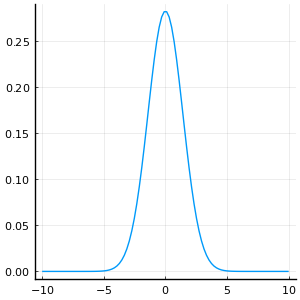

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator
sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [3]:
# test
f= gauss_pdf(;m=0.,σ2=2.)
x= range(-10,stop=10,length=100)
plot(x,f.(x),size=(300,300),label="")

### 2 - By defining a structure, we will easily handle and set the parameters of our Brownian motion.

In [4]:
struct Brownian
    Δ::Float64     # sampling stepsize
    Tmin::Float64  # initial time
    Tmax::Float64  # final time
    B0::Float64    # initial value
    σ2::Float64    # variance
end

In [5]:
#test
B = Brownian(.01,0.,1.,0.,1.)
B.Δ,B.Tmin,B.Tmax,B.B0,B.σ2 

(0.01, 0.0, 1.0, 0.0, 1.0)

In [6]:
#import Pkg
#Pkg.add("LaTeXStrings")
using LaTeXStrings

### 3 - We also specify two functions sample and draw respectively for sampling a Brownian Motion and for plotting.

In [7]:
function sample(B::Brownian)
    # Generates a trajectories of the brownian motion B
    # returns a trajectory on [B.Tmin,B.Tmax]
    N = Int(floor(B.Tmax-B.Tmin)/B.Δ)
    mysample = B.B0*ones(N) + sqrt(B.σ2*B.Δ)*cumsum(randn(N))
    return mysample
end

function draw(B::Brownian ; nb_traj=100,enveloppe=true)
    # Plots trajectories of the brownian motion
    # nb_traj: number of trajectories to be plot
    # enveloppe: plots the enveloppe at B0+(+/-)3std
    #...
    N = Int(floor(B.Tmax-B.Tmin)/B.Δ)
    time_horizon = range(B.Tmin,stop=B.Tmax,length=N)
    fig = plot()
    for i in 1:nb_traj
        mysample = sample(B)
        fig = plot!(time_horizon,mysample, label="")
    end
    
    if enveloppe == true
        upper_env = B.B0*ones(N) + 3*sqrt(B.σ2)*sqrt.(time_horizon)
        lower_env = B.B0*ones(N) - 3*sqrt(B.σ2)*sqrt.(time_horizon)
        fig = plot!(time_horizon,upper_env, label="Upper Enveloppe", c=:red)
        fig = plot!(time_horizon,lower_env, label="Lower Enveloppe", c=:red)
        
    end
    fig = title!("Trajectories of Brownian Motion")
end

draw (generic function with 1 method)

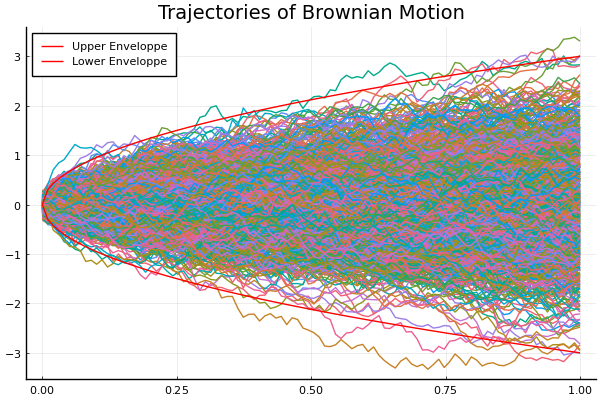

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator
sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [8]:
#test
draw(B;nb_traj=10^3)

### 4 - We plot an histogram of various Brownian motion outputs at a specific time just to check the coherence of our previous results.

In [9]:
function hist(B ; nb_traj=1000, t= :Nan)
    # Plots the histogram at t from nb_traj trajectories
    # of the Brownian motion together with the
    # theoretical distribution
    occur_t = zeros(nb_traj)
    n = Int(floor(((B.Tmax-B.Tmin)/B.Δ)*t))
    N = Int(floor(B.Tmax-B.Tmin)/B.Δ)
    for i in 1:nb_traj
        mysample = sample(B)
        occur_t[i] = mysample[n]
    end

    fig = plot()
    fig = histogram!(occur_t, normed=true, label="Histogram at t")
    f = gauss_pdf(;m=B.B0,σ2=B.σ2*t)
    upper_env = B.B0 + 3*sqrt(B.σ2*t)
    lower_env = B.B0 - 3*sqrt(B.σ2*t)
    x = range(lower_env,stop=upper_env,length=nb_traj)
    fig = plot!(x,f.(x),label="True pdf")
    fig = title!("Histogram and True pdf")
end

hist (generic function with 1 method)

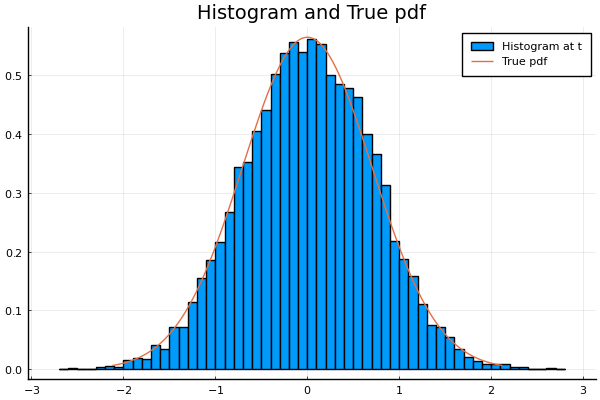

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator
sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [10]:
hist(B ; nb_traj=10^4, t=.5)

- We plotted the true pdf of the data at time and compared it to the histogram. We see that the results are coherent !

### 5 - Analytic solution of the Black-Scholes equation.

In [11]:
# Black-Scholes model
# Equation dX_t = rX_tdt + aX_tdB_t, with r=-1 et a=1
#----------------------------------------------------
r,a,X0  = -1.,1.,1.

function black_scholes_trajectory(t,Bt;r=-1.,a=1.,X0=1.)
    # returns sampling instants and samples
    # of a Black-holes trajectory
    # t:  sampling instants
    # Bt: brownian motion trajectory
    # r:  drift coefficient
    # a:  diffusion coefficient 
    # X0: initial value
    # Bt:  input brownian motion trajectory
    
    α = (r-0.5*a^2).*t+a.*Bt
    return X0 .* exp.(α) 
end

black_scholes_trajectory (generic function with 1 method)

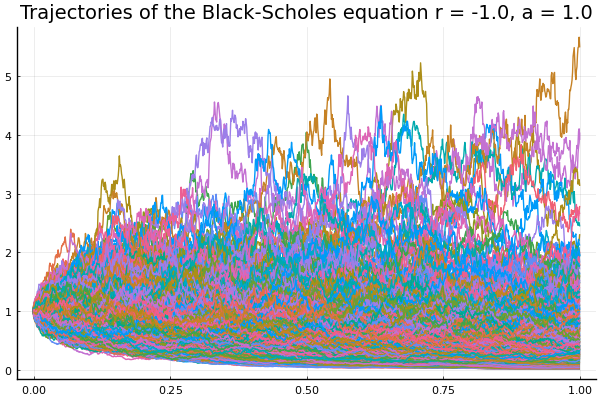

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator
sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [12]:
# test 
B = Brownian(.001,0.,1.,0.,1.)
p = plot()
nb_traj = 10^3

for i in 1:nb_traj
    N = Int(floor(B.Tmax-B.Tmin)/B.Δ)
    t = range(B.Tmin,stop=B.Tmax,length=N)
    Bt = sample(B)
    X = black_scholes_trajectory(t,Bt;r=r,a=a,X0=X0)
    p    = plot!(t,X,label="")
end
p = title!("Trajectories of the Black-Scholes equation r = $r, a = $a")

### 6 - Some numerical solutions of the Balck-Scholes Equation using Euler, Millstein and Runge-Kutta (with order 1.5) methods.

In [13]:
struct model
    dr #drift
    df #diffusion
    Δ_df #derivative of the diffusion
end

In [14]:
m = model((t,x)->r*x,(t,x)->a*x,(t,x)->a)

model(var"#6#9"(), var"#7#10"(), var"#8#11"())

In [15]:
function integrate(m::model,t,Bt;X0=1.0,method="Euler")
    # Returns the trajectory of a stochastic differential equations
    # t:  sampling instant
    # Bt: input brownian motion trajectory
    # X0: initial value
    # method: 'Euler', 'Milstein' or 'Runge_Kutta_1.5'
    # output: trajectory X of the SDE
    N = size(t)[1]
    sol = zeros(N)
    sol[1] = X0
    if method == "Euler"
        for i in 2:N
           sol[i] =  sol[i-1] + m.dr(t[i-1],sol[i-1])*(t[i]-t[i-1]) + m.df(t[i-1],sol[i-1])*(Bt[i]-Bt[i-1])
        end
    elseif method == "Milstein"
        for i in 2:N
            sol[i] =  sol[i-1] + m.dr(t[i-1],sol[i-1])*(t[i]-t[i-1]) + m.df(t[i-1],sol[i-1])*(Bt[i]-Bt[i-1]) + m.Δ_df(t[i-1],sol[i-1])*((Bt[i]-Bt[i-1])^2-(t[i]-t[i-1]))
         end
    elseif method == "Runge_Kutta_1.5"
        for i in 2:N
            X_ = sol[i-1] + m.dr(t[i-1],sol[i-1])*(t[i]-t[i-1]) + m.df(t[i-1],sol[i-1])*sqrt((t[i]-t[i-1]))
            rg = ((Bt[i]-Bt[i-1])^2-(t[i]-t[i-1]))/sqrt((t[i]-t[i-1]))
            sol[i] =  sol[i-1] + m.dr(t[i-1],sol[i-1])*(t[i]-t[i-1]) + m.df(t[i-1],sol[i-1])*(Bt[i]-Bt[i-1]) + 0.5*(m.df(t[i-1],X_) - m.df(t[i-1],sol[i-1]))*rg
        end
    end
    return sol
end

integrate (generic function with 1 method)

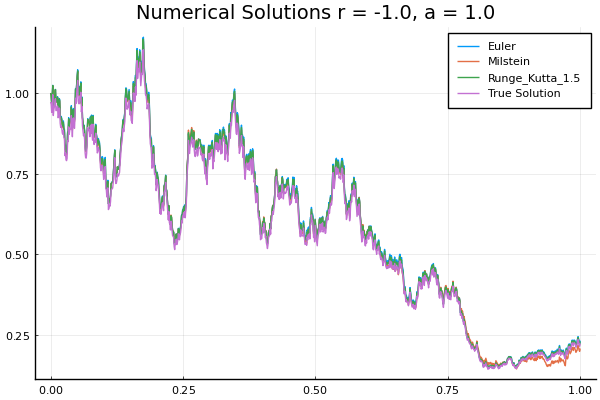

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator
sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [16]:
# Figures

Bt = sample(B)
N = Int(floor(B.Tmax-B.Tmin)/B.Δ)
t = range(B.Tmin,stop=B.Tmax,length=N)
euler_solution = integrate(m,t,Bt;X0=1,method="Euler");
milstein_solution = integrate(m,t,Bt;X0=1,method="Milstein");
runge_Kutta_solution = integrate(m,t,Bt;X0=1,method="Runge_Kutta_1.5");
X = black_scholes_trajectory(t,Bt;r=r,a=a,X0=1)
    

plot(t,euler_solution,label="Euler")
plot!(t,milstein_solution,label="Milstein")
plot!(t,runge_Kutta_solution,label="Runge_Kutta_1.5")
plot!(t,X,label="True Solution")
p = title!("Numerical Solutions r = $r, a = $a")

-------

# <span style="color:#00B8DE">II - Parameter estimation for SDEs </span>

Let's consider the following SDE:
$$
dX_t=b(X_t)dt+\theta\sigma(X_t)dB_t\quad (1)
$$

a regularly sampled trajectory of which is observed at instants $t_i$. Let $X_i=X_{t_i}$ ($i=1,\ldots,n$) 
denote observation variables $x_i,…,x_n$ corresponding observations. First, we shall assume that functions $b(x)$ and
$\sigma(x)$ are known but that $\theta$ is unknown 
 and changes at a given instant that we want to estimate.

#### 1- The discretized version of (1) for Euler sampling method is given by :

$$
X_{t+h}=b(X_t)h + X_t +\theta\sigma(X_t)(B_{t+h}-B_t)\quad 
$$

#### 2- We define the normalized increments as :

$$
Z_i=\theta \dfrac{B_{i+1}−B_i}{\sqrt \Delta}\quad (2)
$$

In [17]:
# We can provide another expression of 𝑍𝑖 :

$$
Z_i=\dfrac{X_{i+1}−X_i-b(X_i)\Delta}{\sigma(X_i)\sqrt \Delta}\quad
$$

$$
\mathcal{N}(Z_i;0,\theta^2)
$$

Let $k$ denote the index value in $\{2,\ldots,n−1\}$ from which the value of $\theta$ 
changes. Let $\theta_1$ denote the value taken by $\theta$ until the time $\tau$ corresponding to $k$
and $\theta_2$ the value it takes after this instant.

#### 3- The maximum likelihood estimators of  𝜃_1  and  𝜃_2  as a function of  𝜏 is given by :

$$
\theta_1^2 = \dfrac{\sum\limits_{i=1}^k Z_i^2}{k}
$$

$$
\theta_2^2 = \dfrac{\sum\limits_{i=k+1}^{n} Z_i^2}{n-k}
$$

$T_{max} - T_{min} = N\Delta$
donc,
$\tau = k\Delta$
et enfin,
$k=\dfrac{\tau N}{T_{max} - T_{min}}$

#### 4- The maximum likelihood estimator of the position 𝑘 is given by :

$\hat{k}=\arg\min_k D_k$, with
$$
D_k=k\log\dfrac{S_k}{k}+(n−k)\log\dfrac{S_n−S_k}{n−k}\quad (3)
$$
and $S_k=\sum^k_{i=1}Z^2_i$.

#### 5- As an example, we consider the Cox-Ingersoll-Ross processus with equation :

$$
dX_t=(a−bX_t)dt+θ\sqrt{X_t}dBt \quad (4)
$$

This model has been used first to model population growth. The solution is given by

$$
X_t=X_0+\dfrac a b (1−e^{−bt})+\theta\int_0^te^{b(u−t)}\sqrt{X_u}dB_u\quad (5)
$$

#### 6- Let $(a,b)=(5,2)$, $\tau=0.6$ and $(\theta_1,\theta_2)=(1,3)$. The aim will then be to provide the best estimates of $\tau$  $\theta_1$ and $\theta_2$ using their maximum likelihood estimators.

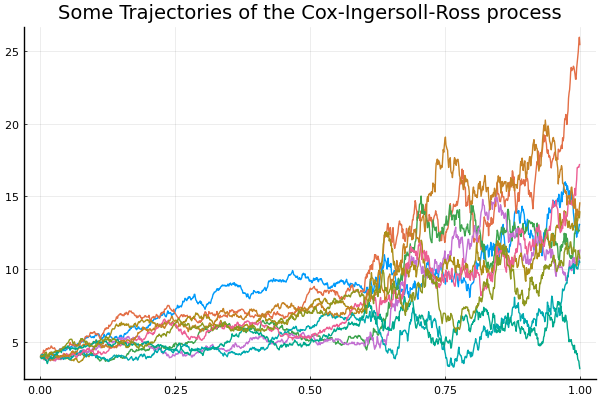

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator
sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [18]:
# Trajectories of Cox-Ingersoll-Ross process
# note that in some cases numerical errors can lead
# to negative values
#------------------------------------------------
a = 5.
b = 2.
τ = .6
θ_1 = 1.
θ_2 = 3.
C_0 = 4.
δ = .001

B = Brownian(δ,0.,1.,0.,1.)

N = Int(floor(B.Tmax-B.Tmin)/B.Δ)
time_horizon = range(B.Tmin,stop=B.Tmax,length=N);

k = Int(floor(τ*N))
nb_traj = 10

p = plot()

for tr in 1:nb_traj
    normal_dist = randn(N)
    C = zeros(N)
    C[1] = C_0
    for i in 2:k
        C[i] = C[i-1] + (a/b)*(1-exp(-b*δ)) + θ_1*sqrt(C[i-1]*δ)*normal_dist[i]
    end
    for i in k+1:N
        C[i] = C[i-1] + (a/b)*(1-exp(-b*δ)) + θ_2*sqrt(C[i-1]*δ)*normal_dist[i]
    end
    p = plot!(time_horizon,C,label="")
end
p = title!("Some Trajectories of the Cox-Ingersoll-Ross process")

#### 7- Let's plot the evolution of the decision variable D_k with respect to $k$ (or $\tau$)

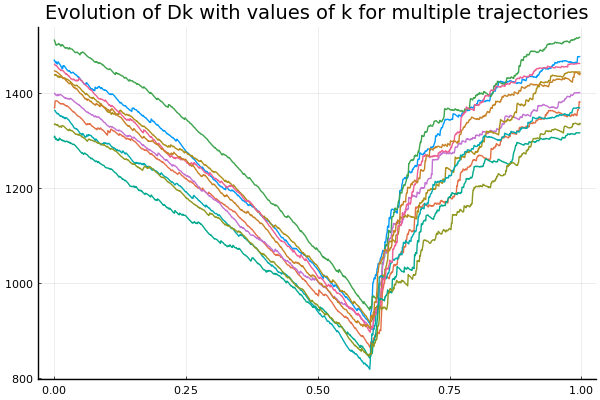

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator
sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [19]:
# Decision variable D_k
#--------------------------------------

p = plot()
K = ones(N-1)
K = cumsum(K).+1

τ_est = zeros(nb_traj)
θ_1_est = zeros(nb_traj)
θ_2_est = zeros(nb_traj)

for tr in 1:nb_traj
    Dk = zeros(N-1)
    normal_dist = randn(N)
    C = zeros(N)
    Z = zeros(N-1)
    C[1] = C_0
    
    for i in 2:k
        C[i] = C[i-1] + (a/b)*(1-exp(-b*δ)) + θ_1*sqrt(C[i-1]*δ)*normal_dist[i]
    end
    for i in k+1:N
        C[i] = C[i-1] + (a/b)*(1-exp(-b*δ)) + θ_2*sqrt(C[i-1]*δ)*normal_dist[i]
    end
    
    for i in 1:size(Z)[1]
        mu = a - b*C[i]
        σ = sqrt(C[i])
        Z[i] = (C[i+1]-C[i]-mu*δ)/(sqrt(δ)*σ)
    end
    
    S_k = cumsum(Z.^2)
    Dk = K .* log.(S_k ./ K) .+ (N .- K) .* log.((S_k[N-1].-S_k) ./ (N.-K))
    
    p = plot!(time_horizon[1:N-2],Dk,label="")
    
    k_est = argmin(Dk[1:size(Dk)[1]-1])
    τ_est[tr] = k_est/N
    θ_1_est[tr] = sqrt(S_k[k_est]/k_est)
    θ_2_est[tr] = sqrt((S_k[N-1]-S_k[k_est])/(N-k_est))
    
    
end
p = title!("Evolution of Dk with values of k for multiple trajectories")

- Estimations of  $\tau$, $\theta_1$ and  $\theta_2$  

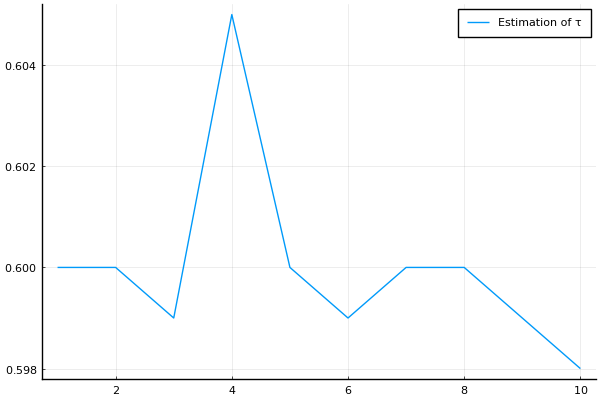

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator
sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [20]:
plot(τ_est, label = "Estimation of τ")

- The value of τ is close to 0.6 as expected !

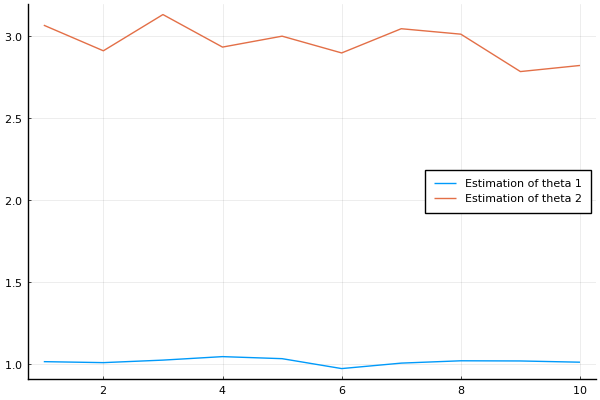

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator
sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [21]:
plot(θ_1_est, label = "Estimation of theta 1")
plot!(θ_2_est, label = "Estimation of theta 2")

- θ_1 is near 1 as expected 
- θ_2 is close to 3 as expected

#### 8- Still assuming that the term $\sigma(X_t)=\sqrt{X_t}$ of the SDE is known but its drift $b(x)$ is know unknown we will use a non-parametric kernel method to estimate $b(x)$ and then apply the method considered above to detect the instant when the diffusion term of the system changes.

Let $K(x)$ > 0 with $\int_{a}^{b} K(x) \,dx = 1$, For instance a Gaussian kernel.

We note $K_h(x)$ = $h^{-1}*K(x/h)$ and estimate a pdf $p_h$ from sample
$x_1$, . . . , $x_n$ by :	

$p_h(x) = \dfrac{\sum\limits_{i=1}^n K_h(x-x_i)}{n}$

- We can show that an approximation of the drift using a non-parametric kernel method is given by :

$$\hat{b}(x) = \dfrac{\sum\limits_{i=1}^n (x_{i+1}-x_i)*K_{h_n}(x-x_i)}{\Delta\sum\limits_{i=1}^n K_{h_n}(x-x_i)}$$

With $h_n$ = $\hat{\sigma}_n(x)$*$n^{-1/5}$ 

In [22]:
using Statistics

In [23]:
# Estimation with unknown drift
# We define a kernel function
#---------------------------------------

h = 0.1 #Standard deviation h = 1.06*std(datax)*n**(-1/5)

function kernel(;m=0.,σ2=h)
    function pdf(x)
        fact1 = 1/sqrt(2*π*σ2)
        cr = (x-m)/sqrt(σ2)
        fact2 = exp(-0.5*cr^2)
    return fact1*fact2
    end
    return pdf
end

kernel (generic function with 1 method)

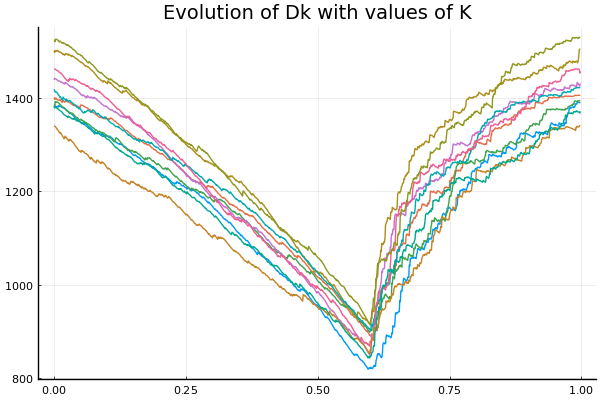

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator
sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [24]:
p = plot()
K = ones(N-1)
K = cumsum(K).+1

τ_new_est = zeros(nb_traj)
θ_1_new_est = zeros(nb_traj)
θ_2_new_est = zeros(nb_traj)

for tr in 1:nb_traj
    Dk = zeros(N-1)
    normal_dist = randn(N)
    C = zeros(N)
    Z = zeros(N-1)
    C[1] = C_0
    
    for i in 2:k
        C[i] = C[i-1] + (a/b)*(1-exp(-b*δ)) + θ_1*sqrt(C[i-1]*δ)*normal_dist[i]
    end
    for i in k+1:N
        C[i] = C[i-1] + (a/b)*(1-exp(-b*δ)) + θ_2*sqrt(C[i-1]*δ)*normal_dist[i]
    end
    
    for i in 1:size(Z)[1]
        
        #Estimation of the drift using a gaussian kernel
        
        h = 1.06*sqrt(var(C))*N^(-1/5)
        mykernel = kernel(;m=0.,σ2=h)
        mu = sum(mykernel.((C[i].-C[1:N-1])) .* (C[2:N]-C[1:N-1]))/(δ*sum(mykernel.((C[i].-C[1:N-1])) ))
        
        σ = sqrt(C[i])
        Z[i] = (C[i+1]-C[i]-mu*δ)/(sqrt(δ)*σ)
    end
    
    S_k = cumsum(Z.^2)
    Dk = K .* log.(S_k ./ K) .+ (N .- K) .* log.((S_k[N-1].-S_k) ./ (N.-K))
    
    p = plot!(time_horizon[1:N-2],Dk,label="")
    
    k_est = argmin(Dk[1:size(Dk)[1]-1])
    τ_new_est[tr] = k_est/N
    θ_1_new_est[tr] = sqrt(S_k[k_est]/k_est)
    θ_2_new_est[tr] = sqrt((S_k[N-1]-S_k[k_est])/(N-k_est))

end
p = title!("Evolution of Dk with values of K")

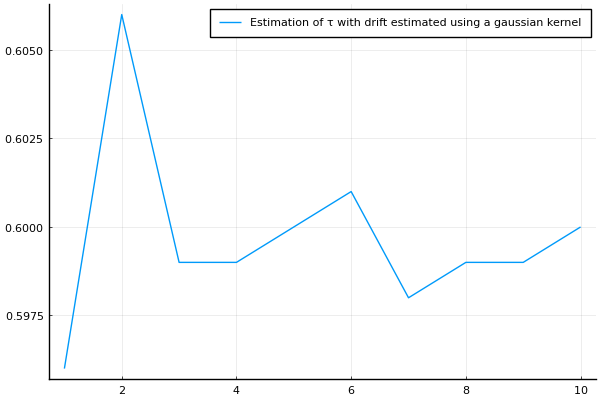

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator
sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [25]:
plot(τ_new_est, label = "Estimation of τ with drift estimated using a gaussian kernel")

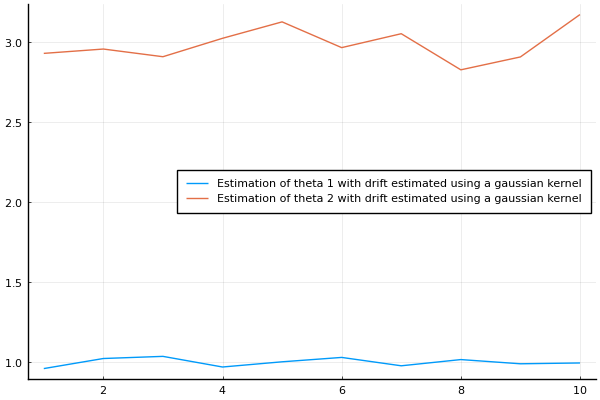

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator
sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [26]:
plot(θ_1_new_est, label = "Estimation of theta 1 with drift estimated using a gaussian kernel")
plot!(θ_2_new_est, label = "Estimation of theta 2 with drift estimated using a gaussian kernel")

- When we use a gaussian kernel to estimate the drift, we are still able to retrieve pretty accurate values of the parameters of our stochastic model.

----------